In [155]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from SimLib import config_sim as conf
from SimLib import sipm_mapping as DAQ
import sys
sys.path.append("/home/viherbos/GITHUB/PETALO_analysis")
import fit_library

%matplotlib nbagg

In [200]:
class TOF_compute(object):
    
    def __init__(self, path, file_name, SIPM, TDC_TE=1, time_bin=5):
        self.p_name = path
        self.f_name = file_name
        self.TDC_TE = TDC_TE
        self.time_bin = time_bin
        
        # SPE response computation
        self.n_sipms    = SIPM['n_sipms']
        self.first_sipm = SIPM['first_sipm']
        
        tau_sipm   = SIPM['tau_sipm']        
        time     = np.arange(0,80000,time_bin)
        alfa = 1.0/tau_sipm[1]
        beta = 1.0/tau_sipm[0]
        t_p = np.log(beta/alfa)/(beta-alfa)
        K = (beta)*np.exp(alfa*t_p)/(beta-alfa)
        self.spe_resp = K*(np.exp(-time*alfa)-np.exp(-time*beta))
        
        os.chdir(path)
        self.tof_wave   = np.array(pd.read_hdf(file_name,key='MC/tof_waveforms'), 
                                   dtype='int')       
        
    def __call__(self,event, time_window):
        event_select    = np.argwhere(self.tof_wave[:,0]==event)
        event_tof       = self.tof_wave[event_select[:,0],1:]            
        event_tof[:,0]  = event_tof[:,0]*-1-self.first_sipm
        # SiPM  |  Timebin  |  Charge

        # Beware of Empty Events
        time_length = np.max(event_tof[:,1])
        #print ("Problema: %d" % time_length)
        pe_table = np.zeros((time_length+1,self.n_sipms))

        for i in range(event_tof.shape[0]):
            pe_table[event_tof[i,1],event_tof[i,0]] = event_tof[i,2]

        if time_window == -1: 
            conv_table = np.zeros((np.max(event_tof[:,1])+1 + self.spe_resp.shape[0]-1,
                                   self.n_sipms))
        else:
            pe_table = pe_table[0:time_window,:]
            conv_table = np.zeros((pe_table.shape[0] + self.spe_resp.shape[0]-1,
                                   self.n_sipms))

        for i in range(self.n_sipms):
            if np.max(pe_table[:,i])>0:
                conv_table[:,i] = np.convolve(pe_table[:,i],self.spe_resp)

        #charge_acc = np.cumsum(conv_table,axis=0)
        charge_acc = np.cumsum(pe_table,axis=0)

        timestamp_v = np.array([])
        for i in range(charge_acc.shape[1]):
            timestamp  = np.argwhere(charge_acc[:,i]>self.TDC_TE)
            if timestamp.size == 0:
                timestamp = 0
            else:
                timestamp  = np.min(timestamp)

            timestamp_v = np.hstack([timestamp_v,timestamp])

        return timestamp_v, charge_acc
    
    


# Extract Event Information

In [201]:
SIPM = {'n_sipms':3500, 'first_sipm':1000, 'tau_sipm':[250,15000]}
TDC = TOF_compute("/mnt/715c6d30-57c4-4aed-a982-551291d8f848/NEUTRINOS/","petit_ring_tof.h5",
                                 SIPM       = SIPM,
                                 TDC_TE     = 1,
                                 time_bin   = 5)

# Configuration Reading

In [202]:
path         = "/home/viherbos/DAQ_DATA/NEUTRINOS/PETit-ring/7mm_pitch/"
jsonfilename = "CUBE"
SIM_CONT=conf.SIM_DATA(filename=path+jsonfilename+".json",read=True)
data = SIM_CONT.data
L1_Slice, Matrix_I, Matrix_O, topo = DAQ.SiPM_Mapping(data,data['L1']['map_style'])


Number of SiPM : 3500 
Number of ASICS : 55 
Minimum Number of L1 : 6 
Available ASICS = 55
Connected ASICS = 55
Instanciated L1 = 6
L1 number 0 has 9 ASICs
L1 number 1 has 9 ASICs
L1 number 2 has 9 ASICs
L1 number 3 has 10 ASICs
L1 number 4 has 9 ASICs
L1 number 5 has 9 ASICs


# Image Composing

In [204]:
timestamp, accu_table = TDC(3556,-1)
print np.min(timestamp[np.argwhere(timestamp>0)])

182.0


In [141]:
time = 280
first_SiPM = 1000
phi_o = np.zeros(Matrix_O.shape)
# Data Matrix Composition
for i in range(Matrix_O.shape[0]):
    for j in range(Matrix_O.shape[1]):
        phi_o[i,j] = accu_table[time,int(Matrix_O[i,j])]

<IPython.core.display.Javascript object>


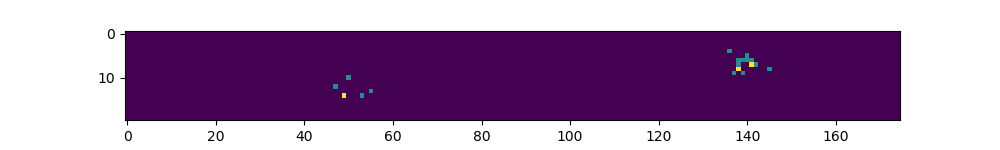

1035.0


In [142]:
fig = plt.figure(figsize=(10,1.5))
plt.imshow(phi_o)
plt.show()
print np.min(timestamp[np.argwhere(timestamp>0)])*5

# TOF computation

In [198]:
t_stamp_v = np.array([]).reshape(0,3500)
ring_dim     = Matrix_O.shape
TOF = np.array([])
j=0

for i in range(10,3556):
    timestamp, charge_acc = TDC(i,500)
    print ("Process Event : %d" % i)
    t_stamp_v = np.vstack([t_stamp_v,timestamp])
    
    timestamp_M    = np.ma.MaskedArray(timestamp,timestamp<1)
    gamma1_sipm    = np.ma.argmin(timestamp_M)
    gamma1_tdc     = np.ma.min(timestamp_M)
    gamma2_sipm    = np.zeros(gamma1_sipm.shape)
    gamma2_tdc     = np.zeros(gamma1_sipm.shape)
    
    gamma1_coord = np.where(Matrix_O==gamma1_sipm)
    print ("Gamma 1 SiPM : %d" % Matrix_O[gamma1_coord])
    
    # Roll SiPM Matrixes to find opposite side of detector
    Xe = np.roll(Matrix_O,-gamma1_coord[1]+ring_dim[1]//4,axis=1)
    # Select opposite side of detector
    Xe_sel = Xe[:,ring_dim[1]//2:]
    Xe_sel_1D = Xe_sel.reshape(-1)
    try:
        OPO_g = timestamp_M[Xe_sel_1D]
        gamma2_tdc = np.ma.min(OPO_g)
        gamma2_coord = Xe_sel_1D[np.ma.argmin(OPO_g)]
        print ("Gamma 2 SiPM : %d" % gamma2_coord)
    except:
        gamma2_tdc = 0

    # Get rid of singles
    TOF_p = (gamma1_tdc - gamma2_tdc)/2
    if np.logical_not(np.isnan(TOF_p)):
        TOF = np.append(TOF,TOF_p)
        print gamma1_tdc, gamma2_tdc, TOF_p
        j += 1
        
    

Process Event : 3556
Gamma 1 SiPM : 2363
Gamma 2 SiPM : 132
Process Event : 3557
Gamma 1 SiPM : 0
Gamma 2 SiPM : 44
Process Event : 3558
Gamma 1 SiPM : 0
Gamma 2 SiPM : 44
Process Event : 3559
Gamma 1 SiPM : 0
Gamma 2 SiPM : 44


<IPython.core.display.Javascript object>


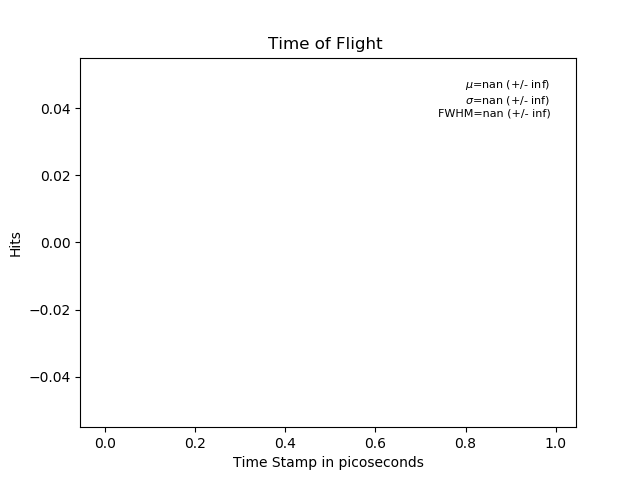

In [207]:
# Introduce a random sign to symmetrize distribution
random_sign = (np.random.rand(len(TOF))>0.5)*-1
random_sign = random_sign + random_sign + 1
TOF = TOF * random_sign  


fit = fit_library.gauss_fit()
fig3 = plt.figure()
data = TOF[(TOF>-400)*(TOF<400)]*5
fit(TOF,100)
fit.plot(axis = fig3.add_subplot(111),
         title = "Time of Flight ",
         xlabel = "Time Stamp in picoseconds",
         ylabel = "Hits",
         res=False, 
         fit=True)

In [206]:
TOF

array([], dtype=float64)